# Детекция лиц с использованием архитектуры VGG16

# 1. Подготовка датасета
В качестве датасета выбран датасет **VGG16** с большим количеством изображений и соотвествующих им координат прямоугольника лиц `(x, y, w, h)`.

## Подготовка аннотаций из датасета
Сначала извлечем аннотации из датасета в формате `(путь_к_изображению, список_координат_лиц_изображения)`. Поскольку датасет большой, а обучать на сильно больших данных не можем ввиду слабого ПК без `GPU`, аннотации для тренировочних данных и для валидации будем брать из папки изображений с тренировочными данными.

In [1]:
from sklearn.model_selection import train_test_split
import cv2
import os

In [2]:
WIDER_FACE_PATH = "C:/Users/PAVILION/Desktop/Coding/Datasets/wider_face/"
WITHOUT_FACE_PATH = "C:/Users/PAVILION/Desktop/Coding/Datasets/random_img_without_face/"
DATASETS_PATH = "C:/Users/PAVILION/Desktop/Coding/Datasets/"

In [3]:
def demonstrate(annots, n):
    for i in range(n):
        # Загружаем изображение
        image = cv2.imread(DATASETS_PATH + annots[i][0])  # путь к файлу
        
        # Получаем размеры изображения
        height, width = image.shape[:2]
        
        for rect in annots[i][1]:
            # Рисуем прямоугольник (рамку)
            # cv2.rectangle(изображение, (x1, y1), (x2, y2), (B, G, R), толщина)
            x, y, w, h = rect
            cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 3)
        
        # Выводим изображение
        cv2.imshow("Image with Frame", image)
        cv2.waitKey(0)  # Ждём нажатия любой клавиши
        cv2.destroyAllWindows()  # Закрываем окно

In [4]:
all_annotations = []
with open(WIDER_FACE_PATH + "wider_face_split/wider_face_train_bbx_gt.txt", 'r') as f:
    lines = f.readlines()
i = 0
while i < len(lines):
    img_name = "wider_face/WIDER_train/images/" + lines[i].strip()
    i += 1
    num_boxes = int(lines[i].strip())
    i += 1
    bboxes = []
    for _ in range(num_boxes):
        if i >= len(lines):
            break
        box_data = list(map(int, lines[i].strip().split()[:4]))
        bboxes.append(box_data)
        i += 1
    # Фильтрация: отбираем изображения с одним лицом площадью > 2000 (w*h) и не относящееся к сложным темам 
    if len(bboxes) == 1 and bboxes != [[]] and\
         bboxes[0][2]*bboxes[0][3] > 1500 and\
         ('3--Riot' or '24--Soldier_Firing' or '25--Soldier_Patrol' or '26--Soldier_Drilling' or '27--Spa' or\
          '34--Baseball' or '36--Football' or '43--Row_Boat' or '52--Photographers' or '53--Raid' or '54--Rescue' or\
          '58--Hockey') not in img_name:
        all_annotations.append((img_name, bboxes))

In [5]:
all_annotations[0]

('wider_face/WIDER_train/images/0--Parade/0_Parade_marchingband_1_849.jpg',
 [[449, 330, 122, 149]])

In [6]:
len(all_annotations)

4382

In [7]:
demonstrate(all_annotations, 3)

Избавимся от нечетких лиц, обработав их с помощью OpenCV. Если OpenCV не найдет лицо, то меняем аннотацию, поставив [[0, 0, 0, 0]] вместо координат лица, неудобного для распознавания.

In [8]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

for i, (img_path, face_coords) in enumerate(all_annotations):
    img = cv2.imread(DATASETS_PATH+img_path)

    if img is None:
        print(f"Не удалось загрузить изображение: {img_path}")
        continue

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    if len(faces) == 0:
        all_annotations[i] = (img_path, [[0, 0, 0, 0]])

In [18]:
len([annotation for annotation in all_annotations if annotation[1] == [[0, 0, 0, 0]]])

1076

Добавление аннотаций изображений без лиц

In [19]:
for filename in os.listdir(WITHOUT_FACE_PATH):
    img_name = os.path.join("random_img_without_face/", filename)
    all_annotations.append((img_name, [[0, 0, 0, 0]]))

In [20]:
len(all_annotations)

7346

In [33]:
print('Аннотаций изображений с лицами:', len([annotation for annotation in all_annotations if annotation[1] != [[0, 0, 0, 0]]]))
print('Аннотаций изображений без лиц:', len([annotation for annotation in all_annotations if annotation[1] == [[0, 0, 0, 0]]]))

Аннотаций изображений с лицами: 3306
Аннотаций изображений без лиц: 4040


In [38]:
demonstrate(all_annotations, 10)

Сохраним наши аннотации в `json`

In [21]:
import json
json_ready = [[path, coords] for (path, coords) in all_annotations]
with open("annotations.json", "w", encoding="utf-8") as f:
    json.dump(json_ready, f, ensure_ascii=False, indent=2)

## Аугментируем данные

In [61]:
import numpy as np
import random
from PIL import Image

def augment_image_and_bbox(image, bbox, transformations):
    img = image.copy()
    x, y, w, h = bbox

    # bbox_np в формате [x_min, y_min, x_max, y_max]
    bbox_np = np.array([x, y, x + w, y + h], dtype=np.float32)

    for transform_name in transformations:
        current_img_width, current_img_height = img.size

        if transform_name == 'flip_horizontal':
            img = img.transpose(Image.FLIP_LEFT_RIGHT)

            old_x_min, old_y_min, old_x_max, old_y_max = bbox_np
            bbox_np[0] = current_img_width - old_x_max
            bbox_np[2] = current_img_width - old_x_min

        elif transform_name == 'translate_small':
            pass
                # dx = random.uniform(-0.05, 0.05) * current_img_width
                # dy = random.uniform(-0.05, 0.05) * current_img_height

                # # Apply the transformation to the image
                # # PIL transform will clip the image if it goes out of bounds
                # img = img.transform(
                #     img.size,
                #     Image.AFFINE,
                #     (1, 0, dx, 0, 1, dy),
                #     fillcolor=0 # Важно: заполнять черным цветом (или другим, если фон)
                # )

                # # Translate bounding box coordinates mathematically
                # translated_bbox_np = bbox_np.copy() # Make a copy to avoid modifying original bbox_np prematurely
                # translated_bbox_np[0] += dx
                # translated_bbox_np[1] += dy
                # translated_bbox_np[2] += dx
                # translated_bbox_np[3] += dy

                # # Clip the translated bounding box to the current (and now potentially clipped) image dimensions
                # # This is crucial because the image itself has been clipped by img.transform
                # new_x_min = max(0, translated_bbox_np[0])
                # new_y_min = max(0, translated_bbox_np[1])
                # new_x_max = min(current_img_width, translated_bbox_np[2])
                # new_y_max = min(current_img_height, translated_bbox_np[3])

                # # Update bbox_np with the clipped values
                # bbox_np = np.array([new_x_min, new_y_min, new_x_max, new_y_max], dtype=np.float32)

                # # If the bounding box becomes invalid (e.g., completely out of bounds), set it to [0,0,0,0]
                # if bbox_np[0] >= bbox_np[2] or bbox_np[1] >= bbox_np[3]:
                #     bbox_np = np.array([0, 0, 0, 0], dtype=np.float32)

        elif transform_name == 'scale_small':
            scale_factor = random.uniform(0.9, 1.1)
            new_width = int(current_img_width * scale_factor)
            new_height = int(current_img_height * scale_factor)

            if new_width > 0 and new_height > 0:
                img = img.resize((new_width, new_height), Image.BICUBIC)
                bbox_np *= scale_factor
            else:
                bbox_np = np.array([0, 0, 0, 0], dtype=np.float32)
                break # Exit if image becomes invalid

    # Final clipping and conversion to [x, y, w, h] format
    final_img_width, final_img_height = img.size

    new_x_min = round(bbox_np[0])
    new_y_min = round(bbox_np[1])
    new_x_max = round(bbox_np[2])
    new_y_max = round(bbox_np[3])

    # Final clipping (redundant for translate, but good for general safety)
    new_x_min = max(0, min(new_x_min, final_img_width))
    new_y_min = max(0, min(new_y_min, final_img_height))
    new_x_max = max(0, min(new_x_max, final_img_width))
    new_y_max = max(0, min(new_y_max, final_img_height))

    new_w = max(0, new_x_max - new_x_min)
    new_h = max(0, new_y_max - new_y_min)

    new_x = new_x_min
    new_y = new_y_min

    return img, [new_x, new_y, new_w, new_h]

In [62]:
import random
import numpy as np

def augment_face_data_with_transforms(all_annotations, output_base_dir=DATASETS_PATH+"augment_images_transformed"):
    os.makedirs(output_base_dir, exist_ok=True)
    augmented_annotations = []
    image_counter = 0
    common_transformations = ['flip_horizontal', 'translate_small', 'scale_small']

    for original_image_path, original_bbox_list in all_annotations:
        if not original_bbox_list:
            print(f"Предупреждение: Пропускаем изображение {original_image_path} из-за отсутствия bbox.")
            continue

        bbox = original_bbox_list[0]

        try:
            full_image_path = os.path.join(DATASETS_PATH, original_image_path)
            original_image = Image.open(full_image_path).convert("RGB")
        except FileNotFoundError:
            print(f"Ошибка: Файл не найден по пути {full_image_path}. Пропускаем.")
            continue
        except Exception as e:
            print(f"Ошибка при открытии изображения {full_image_path}: {e}. Пропускаем.")
            continue

        num_transforms = random.randint(0, len(common_transformations))
        selected_transforms = random.sample(common_transformations, num_transforms)

        augmented_img, augmented_bbox = augment_image_and_bbox(original_image, bbox, selected_transforms)

        new_image_filename = f"aug_{image_counter:05d}_{os.path.basename(original_image_path)}"
        destination_image_path = os.path.join(output_base_dir, new_image_filename)

        augmented_img.save(destination_image_path)
        augmented_annotations.append((os.path.basename(output_base_dir) + "/" + new_image_filename, [augmented_bbox]))
        image_counter += 1

    annotations_path = os.path.join(output_base_dir, "augmented_annotations.txt")
    with open(annotations_path, "w") as f:
        for img_path_relative, bboxes in augmented_annotations:
            f.write(f"{img_path_relative} {bboxes[0][0]} {bboxes[0][1]} {bboxes[0][2]} {bboxes[0][3]}\n")

    print(f"Аугментация завершена. Изображения сохранены в '{output_base_dir}'.")
    print(f"Аугментированные аннотации — в '{annotations_path}'.")
    return augmented_annotations

In [63]:
augmented_data_transformed = augment_face_data_with_transforms(all_annotations)

Аугментация завершена. Изображения сохранены в 'C:/Users/PAVILION/Desktop/Coding/Datasets/augment_images_transformed'.
Аугментированные аннотации — в 'C:/Users/PAVILION/Desktop/Coding/Datasets/augment_images_transformed\augmented_annotations.txt'.


In [64]:
augmented_data_transformed[0]

('augment_images_transformed/aug_00000_0_Parade_marchingband_1_849.jpg',
 [[471, 346, 127, 156]])

In [65]:
demonstrate(augmented_data_transformed, 10)

In [66]:
len(augmented_data_transformed)

7346

In [67]:
# Разделение на train/val
train_annots, val_annots = train_test_split(augmented_data_transformed, test_size=0.3, random_state=42)

## Подготовка данных для обучения
Сначала импортируем библиотеки для работы с изображениями.

In [68]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

Чтобы подготовить данные для обучения нейросети, извлечем по отдельности изображения для тренировки и валидации, координаты лиц для изображений и классовую метку о наличие лица на изображении (`train_images`, `train_bboxes`, `train_labels` и  `val_images`, `val_bboxes`, `val_labels`).

1. Загрузим изображение
2. Изменим размер изображения до стандартного (224x224)
3. Нормализуем значения пикселей
4. Нормализуем координаты ограничивающих прямоугольников (из пикселей в относительные значения от 0 до 1).

In [69]:
# Размер изображения для VGG16
IMG_HEIGHT, IMG_WIDTH = 224, 224

In [70]:
def preprocess_data(annotation_list, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    images = []
    bboxes = []
    labels = []

    for img_path, annots in annotation_list:
        full_path_to_img = DATASETS_PATH + img_path
        
        try:
            with Image.open(full_path_to_img) as original_pil_img:
                original_width, original_height = original_pil_img.size

            img = load_img(full_path_to_img, target_size=target_size)
            img = img_to_array(img) / 255.0
            images.append(img)

            bbox = annots[0]
            x, y, w, h = bbox

            x_min_abs = x
            y_min_abs = y
            x_max_abs = x + w
            y_max_abs = y + h
            
            norm_x_min = x_min_abs / original_width
            norm_y_min = y_min_abs / original_height
            norm_x_max = x_max_abs / original_width
            norm_y_max = y_max_abs / original_height
            
            bboxes.append([norm_x_min, norm_y_min, norm_x_max, norm_y_max])
            
            if bbox != [0, 0, 0, 0]:
                labels.append(1)
            else:
                labels.append(0)

        except FileNotFoundError:
            print(f"Ошибка: Файл не найден по пути {full_path_to_img}. Пропускаем.")
            continue
        except Exception as e:
            print(f"Ошибка при открытии изображения {full_path_to_img}: {e}. Пропускаем.")
            continue

    return np.array(images), np.array(bboxes), np.array(labels)

In [71]:
print("Обработка тренировочных данных...")
train_images, train_bboxes, train_labels = preprocess_data(train_annots)

print(f"Размер тренировочных изображений: {train_images.shape}")
print(f"Размер тренировочных bbox: {train_bboxes.shape}")
print(f"Размер тренировочных меток: {train_labels.shape}")

Обработка тренировочных данных...
Размер тренировочных изображений: (5142, 224, 224, 3)
Размер тренировочных bbox: (5142, 4)
Размер тренировочных меток: (5142,)


In [72]:
print("Обработка валидационных данных...")
val_images, val_bboxes, val_labels = preprocess_data(val_annots)

print(f"Размер валидационных изображений: {val_images.shape}")

Обработка валидационных данных...
Размер валидационных изображений: (2204, 224, 224, 3)


In [73]:
print('Количество пустых изображений в train: ', len(train_labels[train_labels == 0]))
print('Количество пустых изображений в val: ', len(val_labels[val_labels == 0]))

Количество пустых изображений в train:  1502
Количество пустых изображений в val:  595


In [74]:
def show_images_with_bboxes_opencv(images, bboxes, labels=None, num=5):
    for i in range(num):
        img = images[i].copy()  # копируем, чтобы не изменять исходное
        bbox = bboxes[i]
        
        h, w = img.shape[:2]
        x1, y1, x2, y2 = bbox
        # преобразуем нормализованные координаты в пиксели
        pt1 = (int(x1 * w), int(y1 * h))
        pt2 = (int(x2 * w), int(y2 * h))
        
        # Преобразуем изображение из float32 (0..1) в uint8 (0..255)
        img_show = (img * 255).astype(np.uint8)
        img_show = cv2.cvtColor(img_show, cv2.COLOR_RGB2BGR)  # RGB -> BGR для OpenCV
        
        # Рисуем прямоугольник
        cv2.rectangle(img_show, pt1, pt2, color=(0, 0, 255), thickness=2)
        
        # Если есть метки, выводим их на изображение
        if labels is not None:
            label = str(labels[i])
            cv2.putText(img_show, label, (pt1[0], pt1[1]-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)
        
        # Показываем изображение в окне
        cv2.imshow(f'Image {i+1}', img_show)
        cv2.waitKey(0)  # ждем нажатия любой клавиши
        cv2.destroyAllWindows()

In [76]:
show_images_with_bboxes_opencv(train_images, train_bboxes, train_labels, num=10)

# 2. Проектирование и обучение модели
Для построение модели будем использовать архитектуру VGG16, но VGG16 - это классификационная модель. Ее можно использовать как основу для создания модели детекции, используя ее как экстрактор признаков.

В сверточной голове реализуем предсказание 4-х координат одного лица и вероятность наличия лица.

## Создание модели

In [109]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16

In [110]:
# Создаем базовую модель VGG16
vgg_base_model = VGG16(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
vgg_base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [111]:
def build_model(vgg_base): 
    input_layer = Input(shape=(IMG_HEIGHT,IMG_WIDTH,3))
    
    # Используем переданную базовую модель VGG16 как часть нашей архитектуры
    vgg_output = vgg_base(input_layer)

    # Ветвь для классификации (наличие/отсутствие лица)
    f1 = GlobalMaxPooling2D()(vgg_output)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1) # Выход 1 для классификации

    # Ветвь для регрессии (координаты ограничивающей рамки)
    f2 = GlobalAveragePooling2D()(vgg_output) # GlobalAveragePooling2D часто лучше для регрессии
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1) # Выход 4 для координат (x_min, y_min, x_max, y_max)
    
    # Объединяем две ветви в одну модель
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

## Новая loss функция для регрессии

In [112]:
import tensorflow as tf

In [113]:
def iou_loss(y_true, y_pred):
    inter_x_min = tf.maximum(y_true[:, 0], y_pred[:, 0])
    inter_y_min = tf.maximum(y_true[:, 1], y_pred[:, 1])
    inter_x_max = tf.minimum(y_true[:, 2], y_pred[:, 2])
    inter_y_max = tf.minimum(y_true[:, 3], y_pred[:, 3])

    inter_width = tf.maximum(0.0, inter_x_max - inter_x_min)
    inter_height = tf.maximum(0.0, inter_y_max - inter_y_min)
    
    intersection_area = inter_width * inter_height

    true_width = y_true[:, 2] - y_true[:, 0]
    true_height = y_true[:, 3] - y_true[:, 1]
    true_area = true_width * true_height

    pred_width = y_pred[:, 2] - y_pred[:, 0]
    pred_height = y_pred[:, 3] - y_pred[:, 1]
    pred_area = pred_width * pred_height

    union_area = true_area + pred_area - intersection_area
    
    iou = tf.where(tf.equal(union_area, 0), 0.0, intersection_area / union_area)
    
    return 1.0 - iou

In [114]:
classloss = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
regressloss = iou_loss

## Обучение в 2 фазы. С заморозкой весов и с размороженными весами VGG16

In [86]:
# Создаём tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels, train_bboxes))
train_dataset = train_dataset.shuffle(1000).batch(16).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels, val_bboxes))
val_dataset = val_dataset.batch(16).prefetch(tf.data.AUTOTUNE)

In [115]:
class FaceTracker(tf.keras.Model): 
    def __init__(self, eyetracker, **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss_fn, **kwargs):
        self.closs = classloss
        self.lloss_fn = localizationloss_fn 
        self.opt = opt
        super().compile(**kwargs)
    
    def train_step(self, data):
        X, label, bbox = data

        with tf.GradientTape() as tape:
            pred_label, pred_bbox = self.model(X, training=True)
            
            # 1. Вычисляем потерю классификации (всегда)
            class_loss = self.closs(label, pred_label)
            
            # 2. Вычисляем потери локализации для КАЖДОГО примера в батче
            loc_loss_per_sample = self.lloss_fn(tf.cast(bbox, tf.float32), pred_bbox)
            
            # 3. Создаем маску для примеров, где есть лицо (label == 1)
            has_face_mask = tf.cast(label, tf.float32) # Преобразуем метки 0/1 в float32 для умножения

            # 4. Применяем маску к потерям локализации:
            #    Потери для безликих изображений станут 0.
            masked_loc_loss_per_sample = loc_loss_per_sample * has_face_mask
            
            # 5. Вычисляем количество примеров, которые ДЕЙСТВИТЕЛЬНО содержат лицо
            num_face_samples = tf.reduce_sum(has_face_mask)
            
            # 6. Усредняем маскированные потери локализации ТОЛЬКО по примерам с лицами.
            #    tf.where используется для предотвращения деления на ноль, если в батче нет лиц.
            loc_loss = tf.where(tf.equal(num_face_samples, 0.0), 
                                0.0, # Если нет лиц, потеря локализации = 0
                                tf.reduce_sum(masked_loc_loss_per_sample) / num_face_samples)
            
            # Общая потеря
            total_loss = loc_loss + 0.5 * class_loss

        grads = tape.gradient(total_loss, self.model.trainable_variables)
        self.opt.apply_gradients(zip(grads, self.model.trainable_variables))

        return {
            "total_loss": total_loss,
            "class_loss": class_loss,
            "regress_loss": loc_loss # Теперь regress_loss будет показывать реальную потерю для лиц
        }

    def test_step(self, data):
        X, label, bbox = data

        pred_label, pred_bbox = self.model(X, training=False)

        class_loss = self.closs(label, pred_label)
        
        loc_loss_per_sample = self.lloss_fn(tf.cast(bbox, tf.float32), pred_bbox)
        has_face_mask = tf.cast(label, tf.float32)
        masked_loc_loss_per_sample = loc_loss_per_sample * has_face_mask
        
        num_face_samples = tf.reduce_sum(has_face_mask)
        loc_loss = tf.where(tf.equal(num_face_samples, 0.0), 
                            0.0, 
                            tf.reduce_sum(masked_loc_loss_per_sample) / num_face_samples)

        total_loss = loc_loss + 0.5 * class_loss

        return {
            "total_loss": total_loss,
            "class_loss": class_loss,
            "regress_loss": loc_loss
        }

    def call(self, inputs, **kwargs):
        return self.model(inputs, **kwargs)

In [116]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [117]:
# Замораживаем все слои VGG16, чтобы обучались только добавленные слои
for layer in vgg_base_model.layers:
    layer.trainable = False

Создаем "Facetracker" модель, используя замороженный VGG16

In [118]:
facetracker_phase1 = build_model(vgg_base_model)
model_phase1 = FaceTracker(facetracker_phase1)

Оптимизатор для Фазы 1: стандартная скорость обучения

In [119]:
lr_schedule_phase1 = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=len(train_labels)//16,
    decay_rate=0.9,
    staircase=False
)
opt_phase1 = tf.keras.optimizers.Adam(learning_rate=lr_schedule_phase1)

In [120]:
# Компилируем модель для Фазы 1
model_phase1.compile(opt_phase1, classloss, regressloss)

print("\n--- НАЧИНАЕТСЯ ФАЗА 1: ОБУЧЕНИЕ ГОЛОВ (VGG16 ЗАМОРОЖЕН) ---")
# ОБУЧЕНИЕ ФАЗЫ 1
hist_phase1 = model_phase1.fit(train_dataset, epochs=7, validation_data=val_dataset, callbacks=[tensorboard_callback])

# СОХРАНЕНИЕ МОДЕЛИ Фазы 1
model_1 = model_phase1
base_save_dir = r"C:\Users\PAVILION\Desktop\Coding\TrainedModels"
model_save_path_keras = os.path.join(base_save_dir, "face_detection_1_vgg16_bigdata.keras")
try:
    final_model.save(model_save_path_keras)
    print(f"Модель успешно сохранена в: {model_save_path_keras}")
except Exception as e:
    print(f"Ошибка при сохранении модели: {e}")

# Фаза 2: Тонкая настройка (Fine-tuning)
for layer in vgg_base_model.layers:
    layer.trainable = True

# Оптимизатор для Фазы 2: Значительно более низкая скорость обучения
lr_schedule_phase2 = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.00001,
    decay_steps=len(train_labels)//16,
    decay_rate=0.9,
    staircase=False
)
opt_phase2 = tf.keras.optimizers.Adam(learning_rate=lr_schedule_phase2)

model_phase1.compile(opt_phase2, classloss, regressloss)

print("\n--- НАЧИНАЕТСЯ ФАЗА 2: ТОНКАЯ НАСТРОЙКА (VGG16 РАЗМОРОЖЕН) ---")
# ОБУЧЕНИЕ ФАЗЫ 2: продолжаем обучение на большее количество эпох
hist_phase2 = model_phase1.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=[tensorboard_callback])

# СОХРАНЕНИЕ МОДЕЛИ Фазы 2
model_2 = model_phase1
base_save_dir = r"C:\Users\PAVILION\Desktop\Coding\TrainedModels"
model_save_path_keras = os.path.join(base_save_dir, "face_detection_2_vgg16_bigdata.keras")

try:
    final_model.save(model_save_path_keras)
    print(f"Модель успешно сохранена в: {model_save_path_keras}")
except Exception as e:
    print(f"Ошибка при сохранении модели: {e}")


--- НАЧИНАЕТСЯ ФАЗА 1: ОБУЧЕНИЕ ГОЛОВ (VGG16 ЗАМОРОЖЕН) ---
Epoch 1/7
322/322 ━━━━━━━━━━━━━━━━━━━━ 1052s 3s/step - class_loss: 0.5298 - regress_loss: 0.8461 - total_loss: 1.1110 - val_class_loss: 0.6168 - val_regress_loss: 0.8639 - val_total_loss: 1.1723
Epoch 2/7
322/322 ━━━━━━━━━━━━━━━━━━━━ 1015s 3s/step - class_loss: 0.4909 - regress_loss: 0.8258 - total_loss: 1.0712 - val_class_loss: 0.5149 - val_regress_loss: 0.8736 - val_total_loss: 1.1311
Epoch 3/7
322/322 ━━━━━━━━━━━━━━━━━━━━ 1015s 3s/step - class_loss: 0.4763 - regress_loss: 0.8173 - total_loss: 1.0554 - val_class_loss: 0.4931 - val_regress_loss: 0.8612 - val_total_loss: 1.1077
Epoch 4/7
322/322 ━━━━━━━━━━━━━━━━━━━━ 1002s 3s/step - class_loss: 0.4549 - regress_loss: 0.8116 - total_loss: 1.0390 - val_class_loss: 0.7597 - val_regress_loss: 0.8511 - val_total_loss: 1.2309
Epoch 5/7
322/322 ━━━━━━━━━━━━━━━━━━━━ 1008s 3s/step - class_loss: 0.4439 - regress_loss: 0.8061 - total_loss: 1.0280 - val_class_loss: 0.5362 - val_regress_lo

# 3. Оценка качества модели

Для оценки качества модели построим график потерь (`loss`) и точности (`accuracy`) для обучающего и валидационного наборов данных. Это поможет нам понять, есть ли переобучение или недообучение.

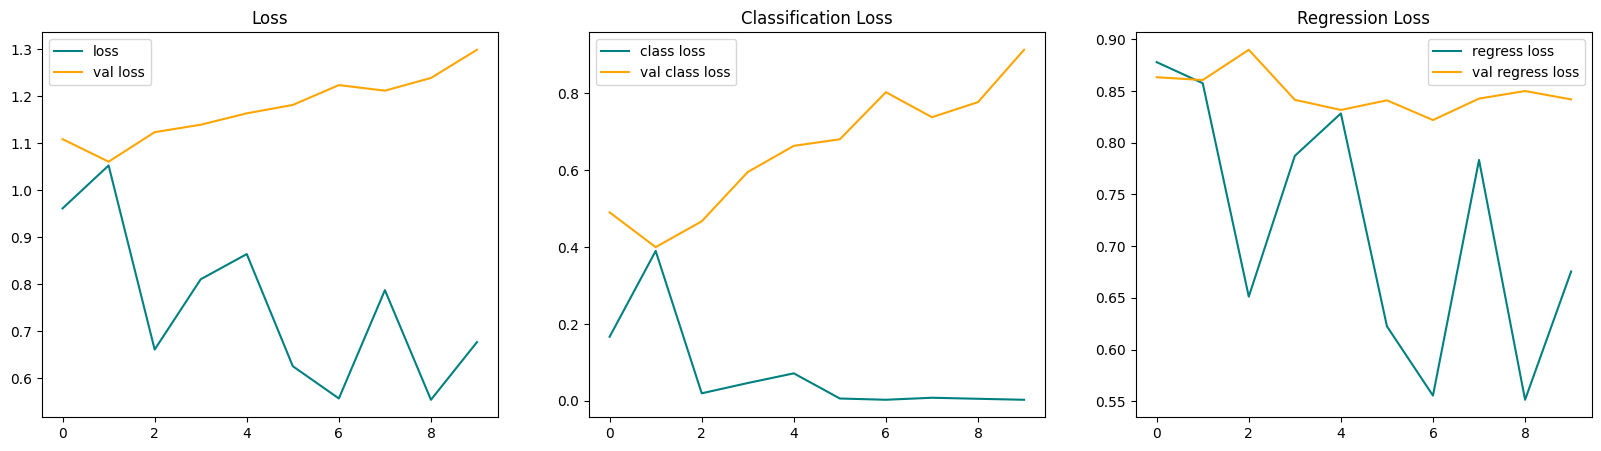

In [124]:
hist = hist_phase2
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [122]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Получаем данные из объекта history
    # Потери для bounding box и классификации
    bbox_loss = history.history['bbox_mae']
    val_bbox_loss = history.history['val_bbox_mae']
    class_loss = history.history['class_loss']
    val_class_loss = history.history['val_class_loss']

    total_loss = history.history['loss']

    epochs = range(1, len(total_loss) + 1)

    # График потерь для Bounding Box (MAE)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, bbox_loss, 'b', label='Потеря BBox на обучении')
    plt.plot(epochs, val_bbox_loss, 'r', label='Потеря BBox на валидации')
    plt.title('Потеря Bounding Box (MAE)')
    plt.xlabel('Эпохи')
    plt.ylabel('Потеря MAE')
    plt.legend()
    plt.grid(True)
    
    # График потерь для классификации (Binary Crossentropy)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, class_loss, 'b', label='Потеря класса на обучении')
    plt.plot(epochs, val_class_loss, 'r', label='Потеря класса на валидации')
    plt.title('Потеря классификации (Binary Crossentropy)')
    plt.xlabel('Эпохи')
    plt.ylabel('Потеря BCE')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Вызов функции для построения графиков
plot_training_history(hist)

NameError: name 'hist' is not defined

## Проверка работы модели в реальном времени

In [128]:
model = model_2

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    orig_h, orig_w = frame.shape[:2]

    # Предобработка изображения
    resized = cv2.resize(frame, (224, 224))
    input_tensor = resized.astype('float32') / 255.0
    input_tensor = np.expand_dims(input_tensor, axis=0)  # (1, 224, 224, 3)

    # Предсказание: модель вернёт (class_pred, bbox_pred)
    class_pred, bbox_pred = model.predict(input_tensor)

    # Обработка результатов (batch = 1)
    class_score = class_pred[0][0]  # scalar (вероятность наличия объекта)
    bbox = bbox_pred[0]             # [x_min, y_min, x_max, y_max] в нормализованных координатах

    # Проверка уверенности
    if class_score > 0.2:
        x1 = int(bbox[0] * orig_w)
        y1 = int(bbox[1] * orig_h)
        x2 = int(bbox[2] * orig_w)
        y2 = int(bbox[3] * orig_h)

        # Рисуем рамку
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame, f"{class_score:.2f}", (x1, y1 - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Отображение окна
    cv2.imshow('Face Detection', frame)

    # Выход по клавише 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Освобождение ресурсов
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [127]:
cap = cv2.VideoCapture(0)

# Освобождение ресурсов
cap.release()
cv2.destroyAllWindows()

In [134]:
def show_predictions_on_images(model, images, true_bboxes=None, labels=None, num=5, image_size=(224, 224)):
    """
    Показывает изображения с предсказанными bbox от модели и, опционально, реальными bbox и метками.
    """
    for i in range(num):
        img = images[i]
        input_img = np.expand_dims(img, axis=0)

        # Предсказание модели (ожидаем [bbox, class])
        pred = model.predict(input_img, verbose=0)
        if isinstance(pred, list) and len(pred) == 2:
            pred_bbox = pred[0][0]  # Извлекаем bbox предсказание (1D массив длины 4)
        else:
            pred_bbox = pred[0]  # Если только bbox — используем как есть

        pred_bbox = np.squeeze(pred_bbox)  # Убираем лишние размерности

        # Подготовка изображения для отображения
        img_disp = (img * 255).astype(np.uint8)
        img_disp = cv2.cvtColor(img_disp, cv2.COLOR_RGB2BGR)

        h, w = image_size

        # Преобразуем нормализованные координаты в пиксели
        x1_pred = int(pred_bbox[0] * w)
        y1_pred = int(pred_bbox[1] * h)
        x2_pred = int(pred_bbox[2] * w)
        y2_pred = int(pred_bbox[3] * h)

        # Рисуем предсказанный bbox (красный)
        cv2.rectangle(img_disp, (x1_pred, y1_pred), (x2_pred, y2_pred), (0, 0, 255), 2)

        # Реальный bbox (зелёный)
        if true_bboxes is not None:
            x1_true = int(true_bboxes[i][0] * w)
            y1_true = int(true_bboxes[i][1] * h)
            x2_true = int(true_bboxes[i][2] * w)
            y2_true = int(true_bboxes[i][3] * h)
            cv2.rectangle(img_disp, (x1_true, y1_true), (x2_true, y2_true), (0, 255, 0), 2)

        # Метка класса (если есть)
        if labels is not None:
            label = str(labels[i])
            cv2.putText(img_disp, f'Label: {label}', (10, 25),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)

        # Показываем изображение
        cv2.imshow(f'Prediction {i+1}', img_disp)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

In [136]:
show_predictions_on_images(model, train_images, train_bboxes, train_labels, num=10, image_size=(224, 224))